# LFP example

In [1]:
import altair as alt
from bayes_window import BayesWindow, models, BayesRegression, LMERegression
from bayes_window.generative_models import generate_fake_lfp

try:
    alt.renderers.enable('altair_saver', fmts=['png'])
except Exception:
    pass

## Make and visualize model oscillation power
40 trials of "theta power" is generated for every animal. It is drawn randomly as a poisson process.

This is repeated for "stimulation" trials, but poisson rate is higher.

In [2]:
# Draw some fake data:
df, df_monster, index_cols, _ = generate_fake_lfp(mouse_response_slope=15, n_trials=30)

Mice vary in their baseline power.

Higher-baseline mice tend to have smaller stim response:

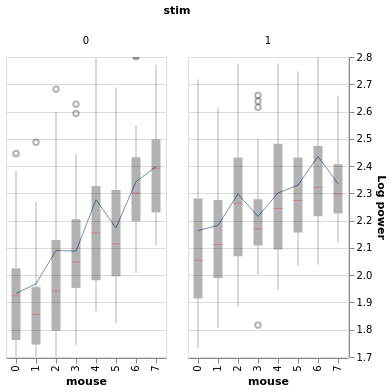

In [3]:
BayesWindow(df=df, y='Log power', treatment='stim', group='mouse').plot(x='mouse').facet(column='stim')


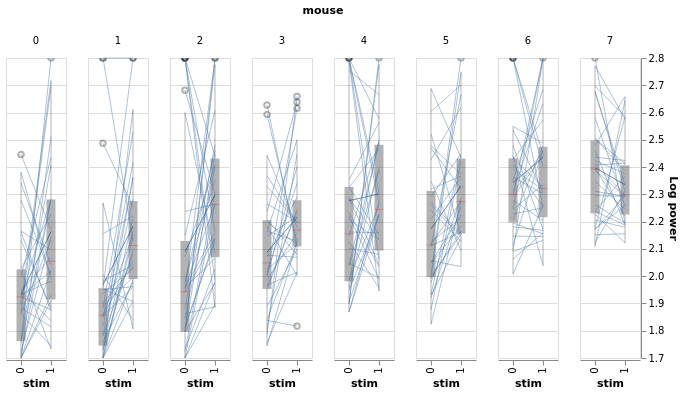

In [4]:
BayesWindow(df=df, y='Log power', treatment='stim', group='mouse', detail='i_trial').data_box_detail().facet(
    column='mouse')

## Fit a Bayesian hierarchical model and plot slopes
In a hierarchical model, parameters are viewed as a sample from a population distribution of parameters. Thus, we view them as being neither entirely different or exactly the same. This is ***partial pooling***:

![hierarchical](../motivation/parpooled.png)
This model allows intercepts to vary across mouse, according to a random effect. We just add a fixed slope for the predictor (i.e all mice will have the same slope):

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

where:
- $j$ is mouse index
- $i$ is observation index
- $y_i$ is observed power
- $x_i$ is 0 (no stimulation) or 1 (stimulation)
- $\epsilon_i \sim N(0, \sigma_y^2)$, error
- $\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$, Random intercept

We set a separate intercept for each mouse, but rather than fitting separate regression models for each mouse, multilevel modeling **shares strength** among mice, allowing for more reasonable inference in mice with little data.

The wrappers in this library allow us to fit and plot this inference in just three lines of code. Under the hood, it uses the following Numpyro code:
```python
# Given: y, treatment, group, n_subjects
# Sample intercepts
a = sample('a', Normal(0, 1))
a_subject = sample('a_subject', Normal(jnp.tile(0, n_subjects), 1))

# Sample variances
sigma_a_subject = sample('sigma_a', HalfNormal(1))
sigma_obs = sample('sigma_obs', HalfNormal(1))

# Sample slope - this is what we are interested in!
b = sample('b_stim', Normal(0, 1))

# Regression equation
theta = a + a_subject[group] * sigma_a_subject + b * treatment

# Sample power
sample('y', Normal(theta, sigma_obs), obs=y)
```


Above is the contents of `model_hier_stim_one_codition.py`, the function passed as argument in line 4 below.

In [5]:
# Initialize:
window = BayesRegression(df=df, y='Power', treatment='stim', group='mouse')
# Fit:
window.fit(model=models.model_hierarchical, add_group_intercept=True,
           add_group_slope=False, robust_slopes=False,
           do_make_change='subtract', dist_y='gamma')

chart_power_difference = (window.chart + window.chart_posterior_kde).properties(title='Posterior')

2021-12-03 15:23:18.050326: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2021-12-03 15:23:18.050471: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 450.142.0 does not match DSO version 450.156.0 -- cannot find working devices in this configuration


changing x to :Q


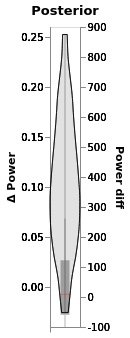

In [6]:
chart_power_difference


In this chart:

- The black line is the 94% posterior highest density interval

- Shading is posterior density

- Barplot comes directly from the data

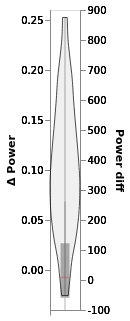

In [7]:
# TODO diff_y is missing from data_and posterior
# chart_power_difference_box
window.data_and_posterior.rename({'Power': 'Power diff'}, axis=1, inplace=True)
# window.plot(x=':O',independent_axes=True).properties(title='Posterior')
window.chart

In this chart:

- The blue dot is the mean of posterior

- The black line is the 94% highest density interval

- The boxplot is made from difference between groups in the data (no fitting)

- Left Y scale is for posterior, right for data

## Compare to non-bayesian approaches
### Off-the-shelf OLS ANOVA

ANOVA does not pick up the effect of stim as significant:

In [8]:
window = LMERegression(df=df, y='Log power', treatment='stim', group='mouse')
window.fit_anova();

Log_power~stim
           sum_sq    df     F  PR(>F)
stim        0.06   1.0  3.31    0.09
Residual    0.26  14.0   NaN     NaN


In [9]:
window = LMERegression(df=df, y='Log power', treatment='stim')
window.fit_anova();

Log_power~stim
           sum_sq     df      F  PR(>F)
stim        1.84    1.0  15.65     0.0
Residual   56.34  478.0    NaN     NaN


In [10]:
window = LMERegression(df=df, y='Power', treatment='stim', group='mouse')
window.fit_anova();

Power~stim
               sum_sq    df     F  PR(>F)
stim       104603.07   1.0  1.15     0.3
Residual  1275260.77  14.0   NaN     NaN


In [11]:
window = LMERegression(df=df, y='Power', treatment='stim')
window.fit_anova();

Power~stim
                 sum_sq     df     F  PR(>F)
stim      3.138092e+06    1.0  1.14    0.29
Residual  1.314873e+09  478.0   NaN     NaN


Including mouse as predictor helps, and we get no interaction:

In [12]:
window.fit_anova(formula='Log_power ~ stim + mouse + mouse*stim');

Log_power ~ stim + mouse + mouse*stim
             sum_sq     df      F  PR(>F)
mouse         6.70    7.0   9.15    0.00
stim          1.84    1.0  17.64    0.00
mouse:stim    1.10    7.0   1.50    0.17
Residual     48.54  464.0    NaN     NaN


#### OLS ANOVA with heteroscedasticity correction

In [13]:
window.fit_anova(formula='Power ~ stim + mouse ', robust="hc3");

Power ~ stim + mouse 
                 sum_sq     df     F  PR(>F)
mouse     5.334404e+07    7.0  2.77    0.01
stim      3.079253e+06    1.0  1.12    0.29
Residual  1.295234e+09  471.0   NaN     NaN


In [14]:
window.fit_anova(formula='Log_power ~ stim +mouse', robust="hc3");

Log_power ~ stim +mouse
           sum_sq     df      F  PR(>F)
mouse       7.90    7.0  10.71     0.0
stim        1.81    1.0  17.18     0.0
Residual   49.64  471.0    NaN     NaN


A linear mixed-effect model shows the effect of stim (slope) as significant. It includes intercepts of mouse, which also vary significantly:

In [15]:
# Initialize:
window = LMERegression(df=df, y='Log power', treatment='stim', group='mouse')
window.fit(add_data=False);

Using formula Log_power ~  C(stim, Treatment) + (1 | mouse)


                         Coef. Std.Err.       z  P>|z| [0.025 0.975]
Intercept                1.950    0.034  57.979  0.000  1.884  2.016
C(stim, Treatment)[T.1]  0.124    0.029   4.205  0.000  0.066  0.182
1 | mouse                0.052    0.007   7.929  0.000  0.039  0.065
Group Var                0.000                                      
changing x to :Q


/home/m/env_jb1/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/m/env_jb1/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/m/env_jb1/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/m/env_jb1/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


changing x to :Q


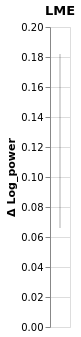

In [16]:
chart_power_difference_lme = window.plot().properties(title='LME')
chart_power_difference_lme

## Compare LME and Bayesian slopes side by side

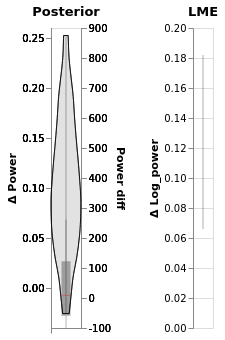

In [17]:
chart_power_difference | chart_power_difference_lme

## Inspect Bayesian result further
Let's take a look at the intercepts and compare them to levels of power in the original data:

changing x to :Q


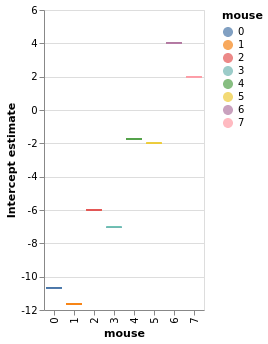

In [18]:
# Initialize:
window = BayesRegression(df=df, y='Power', treatment='stim', group='mouse', detail='i_trial')
# Fit:
window.fit(model=models.model_hierarchical, add_group_intercept=True,
           add_group_slope=False, robust_slopes=False,
           do_make_change='subtract', dist_y='gamma');

chart_detail_and_intercepts = window.plot_intercepts(x='mouse')
window.chart_posterior_intercept

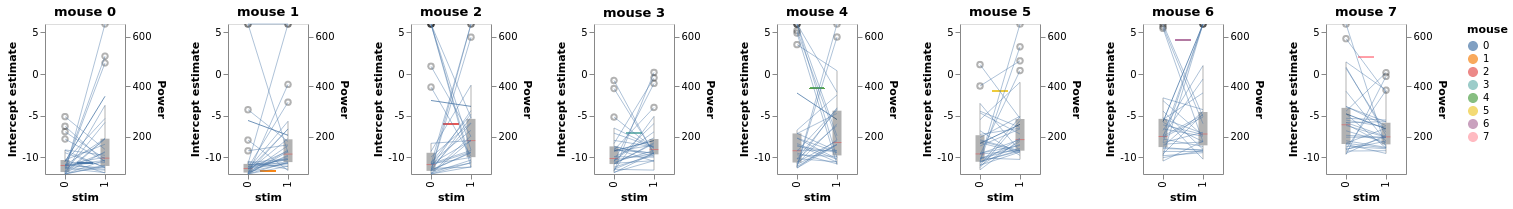

In [19]:
chart_detail_and_intercepts

Our plotting backend's flexibility allows us to easily concatenate multiple charts in the same figures with the | operator:

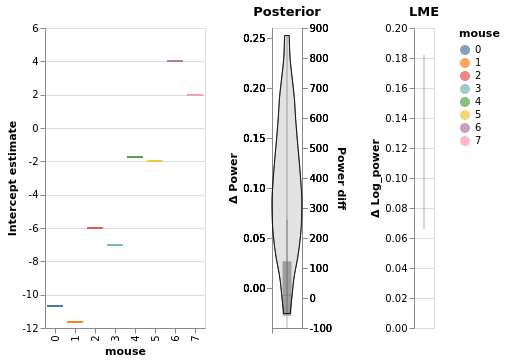

In [20]:
window.chart_posterior_intercept | chart_power_difference | chart_power_difference_lme

## Check for false-positives with null model
They sometimes appear with non-transformed data + "normal" model

changing x to :Q
changing x to :Q


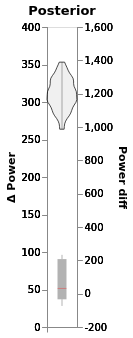

In [21]:
# Initialize:
df_null, df_monster_null, _, _ = generate_fake_lfp(mouse_response_slope=0, n_trials=30)
window = BayesRegression(df=df_null, y='Power', treatment='stim', group='mouse')
# Fit:
window.fit(model=models.model_hierarchical, add_group_intercept=True,
           add_group_slope=False, robust_slopes=False,
           do_make_change='subtract', dist_y='normal')

# Plot:
chart_power_difference = window.plot(independent_axes=False,
                                     ).properties(title='Posterior')

chart_power_difference

This does not happen if we estimate group slopes.

GLM is more robust to no differences in the case of no effect:

changing x to :Q
changing x to :Q


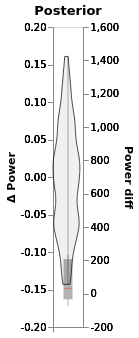

In [22]:
# Initialize:
window = BayesRegression(df=df_null, y='Power', treatment='stim', group='mouse')
# Fit:
window.fit(model=models.model_hierarchical, add_group_intercept=True,
           add_group_slope=False, robust_slopes=False,
           do_make_change='subtract', dist_y='gamma')
# Plot:
window.plot(independent_axes=False,
            ).properties(title='Posterior')


## Include all samples in each trial
The mean of every one of the 30 trials we drew for each mouse is a manifestation of the same underlying process that generates power for each mouse. Let's try to include all samples that come in each trial

In [23]:
# NBVAL_SKIP
# Initialize:
window = BayesRegression(df=df_monster, y='Power', treatment='stim', group='mouse')
# Fit:
window.fit(model=models.model_hierarchical, add_group_intercept=True,
           num_warmup=500, n_draws=160, progress_bar=True,
           add_group_slope=False, robust_slopes=False,
           do_make_change='subtract', dist_y='gamma');

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

changing x to :Q


changing x to :Q


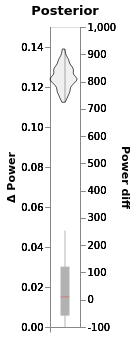

In [24]:
# NBVAL_SKIP
alt.data_transformers.disable_max_rows()
chart_power_difference_monster = window.plot(independent_axes=False).properties(title='Posterior')
chart_power_difference_monster

Much tighter credible intervals here!

Same with linear mixed model:

Using formula Log_power ~  C(stim, Treatment) + (1 | mouse)


/home/m/env_jb1/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                         Coef. Std.Err.        z  P>|z| [0.025 0.975]
Intercept                1.981    0.017  119.105  0.000  1.948  2.013
C(stim, Treatment)[T.1]  0.106    0.002   46.043  0.000  0.101  0.110
1 | mouse                0.049    0.004   13.619  0.000  0.042  0.056
Group Var                0.001    0.001                              
changing x to :Q
changing x to :Q


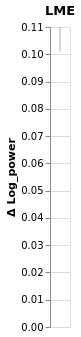

In [25]:
# NBVAL_SKIP
window = LMERegression(df=df_monster,
                         y='Log power', treatment='stim', group='mouse')
window.fit()

chart_power_difference_monster_lme = window.plot().properties(title='LME')
chart_power_difference_monster_lme

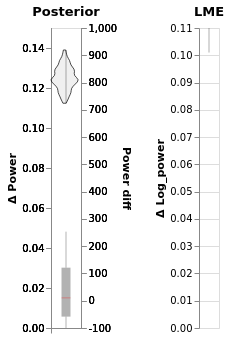

In [26]:
# NBVAL_SKIP
(chart_power_difference_monster | chart_power_difference_monster_lme)
